In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../src/' ) # local version

from ml.preprocessing import *

# Data Preprocessing

## Reading excel sheets

In [2]:
%%time
# file = './drive/My Drive/thesis-workspace/datasets/dataset-residential.csv' # drive
file = '../datasets/dataset-residential.csv' # local
df = pd.read_csv( file, index_col = 'date', parse_dates = [ 'date' ] )
df

CPU times: user 303 ms, sys: 46.8 ms, total: 350 ms
Wall time: 350 ms


,pre,alt,hum,tem,ven,occ
date,,,,,,
2020-05-14 21:08:39,94270.77,604.60,54.49,30.99,1.0,L
2020-05-14 21:08:40,94268.36,604.81,54.46,30.99,1.0,L
2020-05-14 21:08:41,94266.11,605.01,54.46,30.99,1.0,L
2020-05-14 21:08:42,94268.52,604.80,54.49,30.99,1.0,L
2020-05-14 21:08:43,94269.70,604.69,54.50,30.99,1.0,L
...,...,...,...,...,...,...
2020-06-04 23:08:55,94599.23,575.65,57.31,31.95,1.0,M
2020-06-04 23:08:56,94595.97,575.93,57.35,31.95,1.0,M
2020-06-04 23:08:57,94597.73,575.78,57.28,31.94,1.0,M


## Visualization

In [3]:
# %%time
# plot_env_vars( df.index.astype( str ), df[ 'tem' ], df[ 'hum' ], df[ 'occ' ] )
# plot_single( df.index.astype( str ), df[ 'pre' ], 'Pressure' )

# Features Selection

In [4]:
from ml.feature_selection import *
from ml.generation import *

## Recursive Feature Elimination 

In [5]:
x_train, x_test, y_train, y_test = split_data( df, test_size = 0.20 )
x_train, x_test = standardize( x_train, x_test )
selected_rfe = select_k_rfe( x_train, y_train, df.columns[ : -1 ], 1 )
selected_rfe

,rank,selected
hum,1,1
pre,2,0
tem,3,0
ven,4,0
alt,5,0


## 3.2 Selecting K-best

In [6]:
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision = 2)
selected_kbest = select_k_best( x_train, y_train, df.columns[ : -1 ], 3 )
selected_kbest

,score,p-value
tem,"42,166.13",0.00
ven,"41,196.57",0.00
hum,"22,034.33",0.00
alt,"11,741.74",0.00
pre,"11,732.62",0.00


## 3.3 Feature Correlation

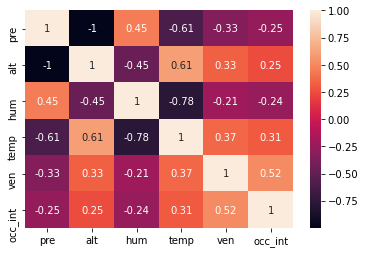

In [7]:
occ_int = df[ 'occ' ].replace( { 'E': 0, 'L':0, 'M':2, 'H':1 } )
temp = pd.concat( [ df, occ_int ], axis = 1 ).dropna( thresh = 2 )
temp.columns = [ 'pre', 'alt', 'hum', 'temp', 'ven', 'occ', 'occ_int' ]

sns.heatmap( temp.corr(), annot = True )

# Datasets Generation

In [8]:
from ml.generation import *
import enum

class DF( enum.Enum ):
    _OR = 0
    _10SEC = 1
    _1MIN = 2
    _5MIN = 3

AGG = [ 'mean' ]
dfs = { DF._OR: df, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None }
grids = { DF._OR: None, DF._10SEC: None, DF._1MIN: None, DF._5MIN: None }

## Different resolutions generation

### 10 sec. avg.

In [9]:
dfs[ DF._10SEC ] = df_10sec_avg( df.reset_index( drop = False ), AGG ).set_index( 'date' )

### 1 minute samples

In [10]:
dfs[ DF._1MIN ] = df_1min_samples( df )

### 5 minutes samples

In [11]:
dfs[ DF._5MIN ] = df_5min_samples( df )

## Data splitting, standarization and balancing

In [12]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._OR: 1, 
    DF._10SEC: 1, 
    DF._1MIN: 1, 
    DF._5MIN: 1 
}

for k, d in dfs.items() :  
    temp = list( split_data( d, test_size = 0.20 ) )
    temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )
    
    print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
        temp[ X_TRAIN ], 
        temp[ Y_TRAIN ], 
        neighbors[ k ] )
    print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
    print()
    
    dfs[ k ] = temp

Before balancing: DF._OR Counter({'L': 162180, 'E': 40737, 'M': 28281, 'H': 5460})
After balancing: DF._OR Counter({'H': 162188, 'E': 162187, 'L': 162180, 'M': 161949})

Before balancing: DF._10SEC Counter({'L': 16223, 'E': 4084, 'M': 2826, 'H': 536})
After balancing: DF._10SEC Counter({'M': 16256, 'L': 16223, 'H': 16216, 'E': 16200})

Before balancing: DF._1MIN Counter({'L': 2730, 'E': 673, 'M': 480, 'H': 92})
After balancing: DF._1MIN Counter({'E': 2737, 'H': 2732, 'L': 2730, 'M': 2724})

Before balancing: DF._5MIN Counter({'L': 553, 'E': 136, 'M': 96, 'H': 19})
After balancing: DF._5MIN Counter({'M': 558, 'E': 556, 'L': 553, 'H': 551})



# Classification

In [13]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from ml.classification import *

params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 3, 4, 6, 8, 10, 11, 12 ]
} ]

## Regular

In [14]:
%%time
for k, df in dfs.items():
    if( k != DF._OR and k != DF._10SEC and k != DF._1MIN ):
        print( 'Dataset ', k )
        train_and_test( 
                DecisionTreeClassifier(), params_dt, 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._5MIN
Best params:  {'criterion': 'gini', 'max_depth': 12}
Training Accuracy 0.9648393868982105
Test Accuracy:  0.9104477611940298
Exception arised while trying to use decision_function: 'DecisionTreeClassifier' object has no attribute 'decision_function', predict_proba will be used instead.
Test ROCauc (OvR): 0.9284903993620426
CPU times: user 5.02 s, sys: 25 ms, total: 5.04 s
Wall time: 5.08 s


## PCA

In [15]:
%%time
for k, df in dfs.items():
    if( k != DF._OR and k != DF._10SEC and k != DF._1MIN ):
        print( 'Dataset ', k )
        grids[ k ] = train_and_test( 
                make_pipeline( PCA( .95 ), DecisionTreeClassifier() ), 
                prefix_params( params_dt, 'decisiontreeclassifier' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )

Dataset  DF._5MIN
Best params:  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 12}
Training Accuracy 0.9438781541722718
Test Accuracy:  0.8557213930348259
Exception arised while trying to use decision_function: 'DecisionTreeClassifier' object has no attribute 'decision_function', predict_proba will be used instead.
Test ROCauc (OvR): 0.8920735211058903
CPU times: user 30.3 s, sys: 238 ms, total: 30.6 s
Wall time: 5.13 s


# Evaluation

In [ ]:
from ml.evaluation import *

## Learning Curves

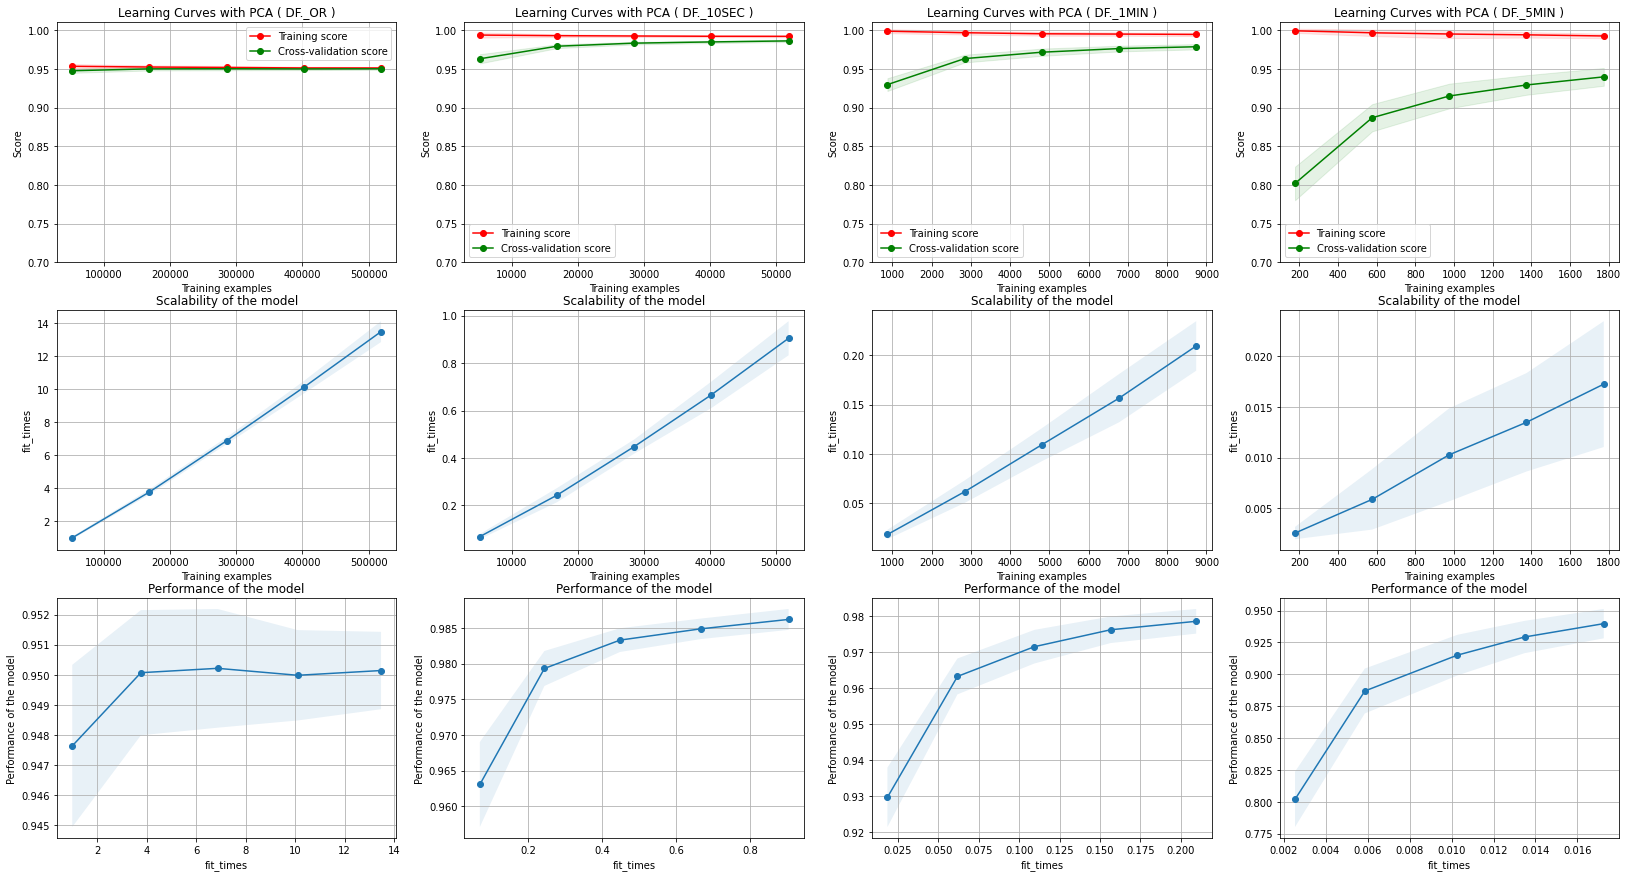

In [ ]:
temp = [ item for item in dfs.items() if item[ 0 ] not in [ ] ]
plot_learning_curves( temp, grids, 'DT' )